# Classification and Error Metrics

In [0]:
#imports
import pandas as pd
import numpy as np
import re
import requests
from os import mkdir
          
def printRed(string): 
  print("\x1b[31m%s\x1b[0m"%(string))

def download_url(url, save_path):  
  r = requests.get(url, stream=True)
  with open(save_path, 'wb') as fd:
      for chunk in r.iter_content(chunk_size=128):
          fd.write(chunk)

# downloading COVID19_open_line_list.csv and time_series_covid_19_confirmed.csv from github
# need to upload COVID19_line_list_data.csv manually

url = 'https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.csv'
download_url(url,'/content/COVID19_open_line_list.csv')
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
download_url(url,'/content/time_series_covid19_confirmed_global.csv')
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/03-31-2020.csv'
download_url(url,'/content/csse_covid_19_daily_reports.csv')

## Introduction
After data analysis and visualization, identify the key features, convert them to suitable numeric format, and use only the processed features for further processing and prediction. Plot and observe the spread of the disease in other countries and identify top countries whose data can be used to predict the spread in Pakistan.

# Section 1

In this section will use [Novel Corona Virus 2019 Dataset](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset) to classify if a patient will survive the COVID-19. You will use `COVID19_line_list_data.csv` and `COVID19_open_line_list.csv` for this assignment.

## Question 1
Explore both the CSVs mentioned above and argue which has more useful features for correctly classifying if a patient is likely to survive the COVID-19. Mention specific features from both files that will and will not correlate to the target (outcome).

In [4]:
def getnoncorr(cols,corr):
  notcorr = list()                
  for i in columns:
    if i not in corr:
      notcorr.append(i)
  return notcorr

printRed('COVID19_open_line_list.csv has more useful features for correctly \n\
classifying if a patient is likely to survive the COVID-19 as it \n\
contains the most important features (symptoms, date_admission_hospital).')

df = pd.read_csv('COVID19_line_list_data.csv')
columns = df.columns[:-6]
df = df[columns]

corr = ['location','country','gender','age','symptom_onset','hosp_visit_date',
        'exposure_start','exposure_end']

printRed('\nCOVID19_line_list_data.csv (correlating to the outcome)')
print(corr)
printRed('\nCOVID19_line_list_data.csv (not correlating to the outcome)')
print(getnoncorr(columns,corr))

df_org = pd.read_csv('COVID19_open_line_list.csv')
columns = df_org.columns
df_org = df_org[columns]           

corr = ['age','sex','city','province','country',
                'date_onset_symptoms','date_admission_hospital','symptoms',
                'lives_in_Wuhan','outcome']


printRed('\nCOVID19_open_line_list.csv (correlating to the outcome)')
print(corr)
printRed('\nCOVID19_open_line_list.csv (not correlating to the outcome)')
print(getnoncorr(columns,corr))

COVID19_open_line_list.csv has more useful features for correctly 
classifying if a patient is likely to survive the COVID-19 as it 
contains the most important features (symptoms, date_admission_hospital).

COVID19_line_list_data.csv (correlating to the outcome)
['location', 'country', 'gender', 'age', 'symptom_onset', 'hosp_visit_date', 'exposure_start', 'exposure_end']

COVID19_line_list_data.csv (not correlating to the outcome)
['id', 'case_in_country', 'reporting date', 'Unnamed: 3', 'summary', 'If_onset_approximated', 'visiting Wuhan', 'from Wuhan', 'death', 'recovered', 'symptom', 'source', 'link']


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,10,11,13,14,15,16,17,18,19,20,22,23,24,25,26,27,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



COVID19_open_line_list.csv (correlating to the outcome)
['age', 'sex', 'city', 'province', 'country', 'date_onset_symptoms', 'date_admission_hospital', 'symptoms', 'lives_in_Wuhan', 'outcome']

COVID19_open_line_list.csv (not correlating to the outcome)
['ID', 'wuhan(0)_not_wuhan(1)', 'latitude', 'longitude', 'geo_resolution', 'date_confirmation', 'travel_history_dates', 'travel_history_location', 'reported_market_exposure', 'additional_information', 'chronic_disease_binary', 'chronic_disease', 'source', 'sequence_available', 'date_death_or_discharge', 'notes_for_discussion', 'location', 'admin3', 'admin2', 'admin1', 'country_new', 'admin_id', 'data_moderator_initials', 'travel_history_binary']


## Question 2

Import the chosen file and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Remove extra feature columns
* Encode the non-numeric values as an integer
* Determine the breakdown of target values

In [0]:
#encoding symptoms

def formatsymp(row, st, splitt=True):
  if splitt:
    row = row.split(st)
  for i in range(len(row)):
    row[i] = row[i].strip().lower()    
    if 'fever' in row[i]:
      row[i] = 'fever'
  return row

def extractsymptoms(row):
  row = str(row)
  if ',' in row:
    return formatsymp(row, ',')
  elif ';' in row:
    return formatsymp(row, ';')
  elif 'and' in row:
    return formatsymp(row, 'and')
  else:
    return formatsymp([row], '', False)

def addsymp(symp, uniq):
  add = 0
  for i in symp:
    add+= uniq.index(i)
  return add


def encodesymp(col):
  uniq = list()
  encoded = list()
  for i in col:
    symptoms = extractsymptoms(i) #extracting individial symptoms
    for s in symptoms:
      if s not in uniq:
        uniq.append(s)
    encoded.append(addsymp(symptoms, uniq)) #encoding by adding symptoms values
  return uniq, encoded

In [0]:
#encoding dates (date_admission_hospital - date_onset_symptoms)
from datetime import date 

def difdays(a,b):
  try:
    date1 = date(int(a[2][:4]),int(a[1]),int(a[0]))
  except:
    date1 = date(int(a[2]),int(a[0]),int(a[1]))
  try:
    date2 = date(int(b[2]),int(b[1]),int(b[0]))
  except:
    date2 = date(int(b[2]),int(b[0]),int(b[1]))
  diff = (date2-date1).days
  if diff<0:
    diff=0
  return diff

def encodedates(d1,d2): 
  encoded = list()
  summ = list()
  for i in range(len(d1)):
    if '.' in d1[i] and '.' in d2[i]:
      a = d1[i].split('.')
      b = d2[i].split('.')
      if len(a)==3 and len(b)==3:
        diff = difdays(a,b)*1.0
        encoded.append(diff)
        summ.append(diff)
      else:
        a[2] = a[2][:4]
        b[2] = b[2][:4]
        diff = difdays(a[:3],b[:3])*1.0
        encoded.append(diff)
        summ.append(diff)
    else:
      encoded.append('~')
  encoded = np.array(encoded)
  avg = round(sum(summ)/len(summ))
  return avg, np.where(encoded=='~',avg,encoded).astype(float) # replacing no data with avg

In [0]:
#encoding lives_in_Wuhan

def encodewuhan(col):
  encoded = list()
  for i in col:
    if i=='yes' or 'Wuhan' in i:
      encoded.append(1)
    else:
      encoded.append(0)
  return encoded

In [0]:
def encodeage(col):
  encoded = list()
  summ = list()
  for i in col:
    if i!='~':
      if '-' in str(i):
        ind = i.index('-')
        age = i[ind+1:]
        if len(age)==0:
          age = i[:ind]
        summ.append(int(age))
        encoded.append(int(age))
      else:
        summ.append(int(age))
        encoded.append(int(age))
    else:
      encoded.append('~')

  encoded = np.array(encoded)
  avg = round(sum(summ)/len(summ))
  return avg, np.where(encoded=='~',avg,encoded).astype(int)  # replacing no data with avg

In [0]:
def encodesex(col):
  encoded = list()
  for i in col:
    if i=='female':
      encoded.append(1)
    elif i=='male':
      encoded.append(2)
    else:
      encoded.append(0)
  return encoded

In [0]:
def encodecpc(cpc):
  uniqdict = dict()
  encoded = list()
  columns = ['city','province','country']
  for i in columns:
    enc = list()
    uniq = ['~']
    col = cpc[i].values
    for j in col:
      if j not in uniq:
        uniq.append(j)
      enc.append(uniq.index(j))
      
    encoded.append(enc)
    uniqdict.update({i:uniq})

  return uniqdict,encoded

In [0]:
def formatoutcome(i):
  dead = ['dead','death','deceased','died']
  stable = ['alive','symptoms only improved with cough. currently hospitalized for follow-up.']
  unstable = ['severe','severe illness','unstable']
  if i in dead:
    i = 'dead'
  elif 'critical condition' in i:
    i = 'dead'
  elif i in unstable:
    i = 'dead'
    
  elif 'discharge' in i:
    i = 'recovered'
  elif 'recover' in i:
    i = 'recovered'
  elif 'released' in i:
    i = 'recovered'
  elif 'not hospitalized' in i:
    i = 'recovered'
  elif 'stable' in i:
    i = 'recovered'
  elif 'treat' in i:
    i = 'recovered'
  elif i in stable:
    i = 'recovered'

  return i

def encodeoutcome(col):
  col = [x.lower() for x in col]
  uniq = list()
  encoded = list()
  for i in col:
    i = formatoutcome(i)
    if i not in uniq:
      uniq.append(i)
    encoded.append(uniq.index(i))

  return uniq,encoded     


In [12]:
df = df_org.copy()
df = df[corr]
df = df.replace(np.nan,'~')
df = df[df['outcome'] != '~']

age = df['age'].values
sex = df['sex'].values
cpc = df[['city','province','country']]
allsymp = df['symptoms'].values
onsetsymp = df['date_onset_symptoms'].values
admissymp = df['date_admission_hospital'].values
liveswuhan = df['lives_in_Wuhan'].values
outcome = df['outcome'].values

avgage, encage = encodeage(age)                       # special encoding for age
encsex = encodesex(sex)                               # special encoding for sex
uniqcpc, enccpc = encodecpc(cpc)                      # special encoding for city, province, country (cpc)
uniqsymp, encsymp = encodesymp(allsymp)               # special encoding for symptoms
avgdate, encdates = encodedates(onsetsymp, admissymp) # special encoding for dates (date_admission_hospital - date_onset_symptoms)
encwuhan = encodewuhan(liveswuhan)                    # special encoding for lives_in_Wuhan
uniqoutcome, encoutcome = encodeoutcome(outcome)      # special encoding for outcome

encdf = df.copy()
encdf['age'] = encage
encdf['sex'] = encsex
encdf['city'] = enccpc[0]
encdf['province'] = enccpc[1]
encdf['country'] = enccpc[2]
encdf['symptoms'] = encsymp
encdf['date_admission_hospital'] = encdates
encdf = encdf.drop(['date_onset_symptoms'],axis=1)
encdf['lives_in_Wuhan'] = encwuhan
encdf['outcome'] = encoutcome

encdf

,age,sex,city,province,country,date_admission_hospital,symptoms,lives_in_Wuhan,outcome
3,59,2,1,1,1,4.0,0,0,0
32,72,0,2,2,2,4.0,0,0,0
33,72,0,2,2,2,4.0,0,0,0
34,72,0,3,2,2,4.0,0,0,0
35,72,0,4,2,2,4.0,0,0,0
...,...,...,...,...,...,...,...,...,...
175416,59,2,96,49,15,1.0,0,0,0
186790,67,0,45,30,1,4.0,0,0,1
196205,29,1,73,49,15,0.0,0,0,0
207811,80,1,164,87,1,4.0,0,0,1


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

totalclasses = np.bincount(encoutcome)
printRed(f'{uniqoutcome[0]}: {totalclasses[0]},\t{uniqoutcome[1]}: {totalclasses[1]}')

X = encdf[[col for col in encdf.columns if col != 'outcome']].values
y = encdf['outcome'].values
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)

count=1
for train_index, test_index in sss.split(X, y):
  y_train = y[train_index]
  y_test = y[test_index]
  traincr = np.bincount(y_train) / totalclasses
  testcr = np.bincount(y_test) / totalclasses
  print(f'Split Ratio TRAIN #{count} {traincr}',f'\tSplit Ratio TEST #{count} {testcr}')
  count+=1

recovered: 668,	dead: 189
Split Ratio TRAIN #1 [0.6991018 0.6984127] 	Split Ratio TEST #1 [0.3008982 0.3015873]


## Question 4

Let's now fit a Naive Bayes classifier to this data in order to predict "outcome".

* Pick the appropriate type of Naive Bayes given the nature of your dataset (data types of columns).Choices are:
    * GaussianNB
    * MultinomialNB
    * BernoulliNB
* Use `cross_val_score` to see how well your choice works.

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

In [15]:
printRed('Since the features have discrete values, I will choose MultinomialNB\n')

cv = 5
mnb = MultinomialNB()
mcvs = cross_val_score(mnb, X, y, cv=cv, n_jobs=-1)
mavg = str(np.mean(mcvs)*100)[:4]
print(f'MultinomialNB Cross Val Score: {mcvs}\n')
printRed(f'My choice works very well giving an average cross val score of {mavg} %')

Since the features have discrete values, I will choose MultinomialNB

MultinomialNB Cross Val Score: [0.70930233 0.78488372 0.81871345 0.9122807  0.30994152]

My choice works very well giving an average cross val score of 70.7 %


## Question 5

Now let's try all types of Naive Bayes and observe what happens

* Compare the cross validation scores for Gaussian, Bernouilli and Multinomial Naive Bayes.
* Why is BernoulliNB performing like it does?

In [16]:
gnb = GaussianNB()
gcvs = cross_val_score(gnb, X, y, cv=cv, n_jobs=-1)
gavg = str(np.mean(gcvs)*100)[:4]
print(f'GaussianNB Cross Val Score:\t{gcvs},\tAverage acc: {gavg} %\n')

mnb = MultinomialNB()
mcvs = cross_val_score(mnb, X, y, cv=cv, n_jobs=-1)
mavg = str(np.mean(mcvs)*100)[:4]
print(f'MultinomialNB Cross Val Score:\t{mcvs},\tAverage acc: {mavg} %\n')

bnb = BernoulliNB()
bcvs = cross_val_score(bnb, X, y, cv=cv, n_jobs=-1)
bavg = str(np.mean(bcvs)*100)[:4]
print(f'BernoulliNB Cross Val Score:\t{bcvs},\tAverage acc: {bavg} %\n')
printRed(f'BernoulliNB has {bavg} % score due to the output features being binary (0,1)')

GaussianNB Cross Val Score:	[0.68023256 0.71511628 0.83040936 0.87134503 0.53216374],	Average acc: 72.5 %

MultinomialNB Cross Val Score:	[0.70930233 0.78488372 0.81871345 0.9122807  0.30994152],	Average acc: 70.7 %

BernoulliNB Cross Val Score:	[0.63953488 0.90116279 0.84210526 0.86549708 0.69590643],	Average acc: 78.8 %

BernoulliNB has 78.8 % score due to the output features being binary (0,1)


## Question 6

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix (plot)

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

	GaussianNB
Accuracy:	0.8527131782945736
Precision:	0.6862745098039216
Recall:		0.6140350877192983
fscore:		0.6481481481481481


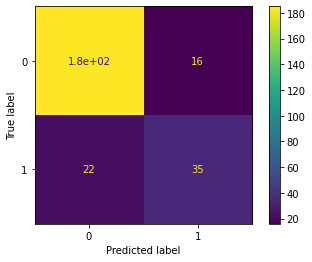

In [18]:
def getdetails(y_true, y_pred):
  acc = accuracy_score(y_true, y_pred)
  prc = precision_score(y_true, y_pred, average='binary')
  rcl = recall_score(y_true, y_pred, average='binary')
  fsc = f1_score(y_true, y_pred, average='binary')
  print(f'Accuracy:\t{acc}\nPrecision:\t{prc}\nRecall:\t\t{rcl}\nfscore:\t\t{fsc}')

def getall(clf, X, y, splits):
  for train_index, test_index in splits:
    clf.fit(X[train_index], y[train_index])    
    y_pred = clf.predict(X[test_index])
    getdetails(y[test_index], y_pred)
    plot_confusion_matrix(clf, X[test_index], y[test_index])

printRed('\tGaussianNB')
getall(GaussianNB(), X, y, sss.split(X,y))

	MultinomialNB
Accuracy:	0.7325581395348837
Precision:	0.43023255813953487
Recall:		0.6491228070175439
fscore:		0.5174825174825174


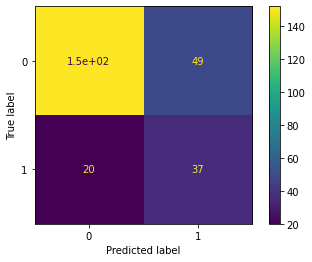

In [19]:
printRed('\tMultinomialNB')
getall(MultinomialNB(), X, y, sss.split(X,y))

	BernoulliNB
Accuracy:	0.8333333333333334
Precision:	0.625
Recall:		0.6140350877192983
fscore:		0.6194690265486725


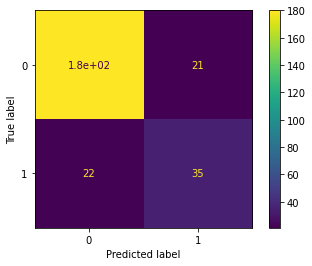

In [20]:
printRed('\tBernoulliNB')
getall(BernoulliNB(), X, y, sss.split(X,y))

## Question 7
Let's dive more into the feature analysis.
* Create a bar plot showing the correlations between each column and `outcome`
* Pick the most 5 correlated fields (using the absolute value of correlations) and create new `X`
* Re-train your chosen Naive Bayes classifier to this data, and compare results

age                        0.095375
sex                        0.246629
city                       0.326870
province                   0.318722
country                    0.075458
date_admission_hospital    0.092647
symptoms                   0.452854
lives_in_Wuhan             0.185403
outcome                    1.000000
Name: outcome, dtype: float64


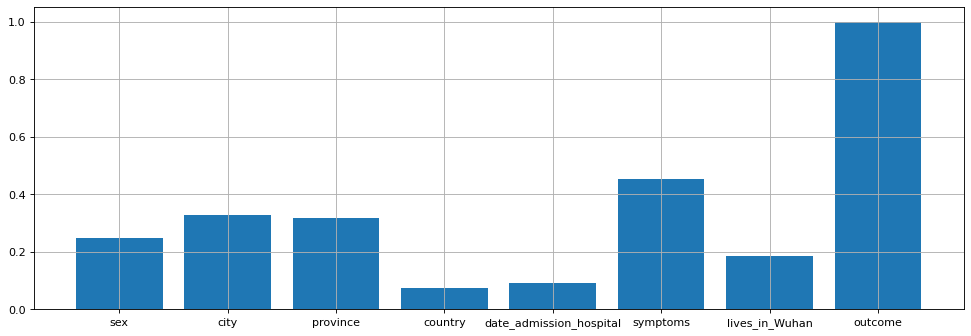

In [25]:
corr_matrix = encdf.corr()['outcome'].abs()
print(corr_matrix)

xaxis = corr_matrix[1:].keys()
yaxis = corr_matrix[1:]

plt.figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.bar(xaxis,yaxis)
plt.grid(True)
plt.show()

corr_matrix = corr_matrix.sort_values(ascending=False)
xaxis = corr_matrix[1:].keys()
topcols = list(xaxis[:5])
topcols.append('outcome')

newdf = encdf.copy()
newdf = newdf[topcols]

Retraining chosen MultinomialNB

MultinomialNB Cross Val Score: [0.71511628 0.8372093  0.83040936 0.91812865 0.73684211]

Average cross val score has increased from 70.7 % to 80.7 %

Accuracy:	0.8449612403100775
Precision:	0.6808510638297872
Recall:		0.5614035087719298
fscore:		0.6153846153846153


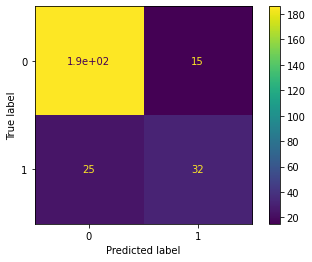

In [26]:
printRed('Retraining chosen MultinomialNB\n')

X_new = newdf[[col for col in newdf.columns if col != 'outcome']].values
y_new = newdf['outcome'].values

cv = 5
mnb = MultinomialNB()
mcvs = cross_val_score(mnb, X_new, y_new, cv=cv, n_jobs=-1)
mavg_new = str(np.mean(mcvs)*100)[:4]
print(f'MultinomialNB Cross Val Score: {mcvs}\n')
printRed(f'Average cross val score has increased from {mavg} % to {mavg_new} %\n')

getall(MultinomialNB(), X_new, y_new, sss.split(X_new,y_new))

<hr>

# Section 2

In this section will use [Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE](https://github.com/CSSEGISandData/COVID-19) to observe the spreading trend of COVID-19. You are required to use the data reported till **31-March-2020**.

## Question 1
Use `time_series_covid19_confirmed_global.csv` and plot the trend of disease spread in 10 most affected countries.

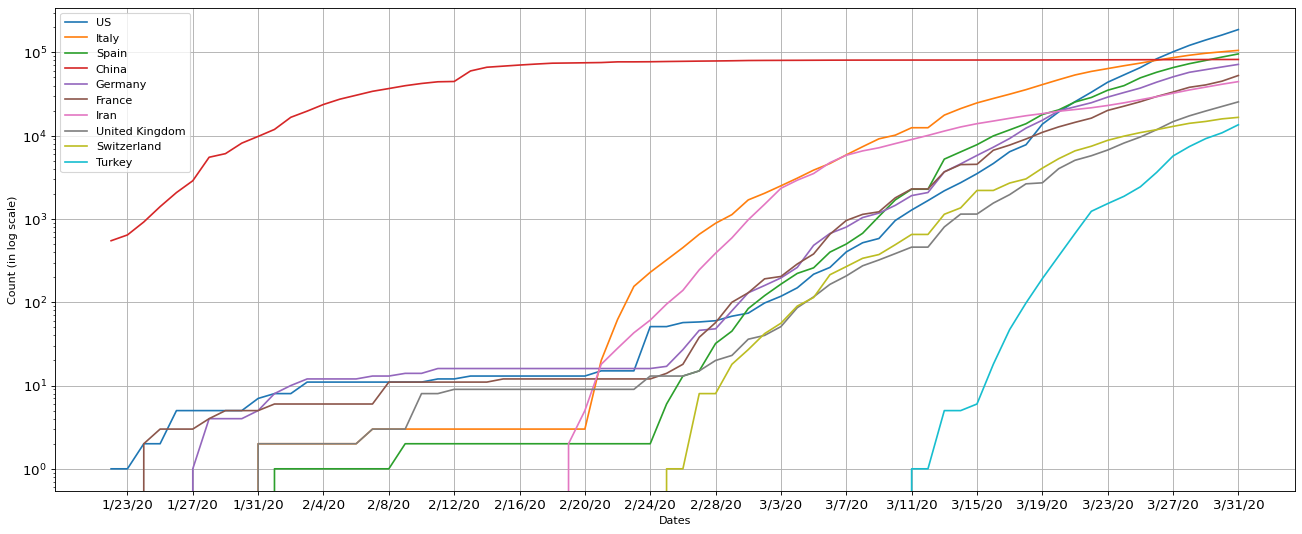

In [80]:
def countrywise(df, allCountries, uniqcountries):
  lists = list()
  for i in uniqcountries:
    index = np.where(allCountries == i)
    rows = df.iloc[index].values[:,4:]
    confirmsum = rows.sum(axis=0)
    lists.append([i,confirmsum])
  return lists

stwodf = pd.read_csv('time_series_covid19_confirmed_global.csv')
stwodf = stwodf.iloc[:,:14+29+31] #get first columns till 31st March
cols = stwodf.columns[4:]

allcountries = stwodf['Country/Region'].values
uniqcountries = np.unique(allcountries)

cnt = countrywise(stwodf, allcountries, uniqcountries)
cntdesc = np.array(sorted(cnt,key=lambda l:l[1][-1], reverse=True)) #descending order wrt 2nd column
topten = cntdesc[:10]

plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
for i in range(10):
  plt.plot(cols, topten[:,1][i], label = topten[:,0][i])
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(np.arange(1, len(cols),4))
plt.xlabel('Dates')
plt.ylabel('Count (in log scale)')
plt.grid(True)
plt.legend()
plt.show()

## Question 2
Use `csse_covid_19_daily_reports` to compare the mortality and survival rates in 10 most affected countries as of 31-March-2020.

In [28]:
def gettopcountries(uniqcnt, drdf):  
  allcnt = list()
  for i in uniqcnt:
    rows = drdf.loc[drdf['Country_Region'] == i]
    confirmed = rows['Confirmed'].sum()
    deaths = rows['Deaths'].sum()
    recovered = rows['Recovered'].sum()
    allcnt.append([i,confirmed,deaths,recovered])
  return allcnt

def formats(a,b):
  return str(a/b*100)[:4]

def getrates(countries):
  for i in countries:
    printRed(i[0])
    print(f'Mortality Rate: {formats(i[2],i[1])} % \tSurvival Rate: {formats(i[2],i[1])} %')

drdf = pd.read_csv('csse_covid_19_daily_reports.csv')
uniqcnt = np.unique(drdf['Country_Region'].values)

allcnt = gettopcountries(uniqcnt, drdf)
topcnt = sorted(allcnt,key=lambda x: x[1], reverse=True)[:10]
getrates(topcnt)

US
Mortality Rate: 2.05 % 	Survival Rate: 2.05 %
Italy
Mortality Rate: 11.7 % 	Survival Rate: 11.7 %
Spain
Mortality Rate: 8.82 % 	Survival Rate: 8.82 %
China
Mortality Rate: 4.02 % 	Survival Rate: 4.02 %
Germany
Mortality Rate: 1.07 % 	Survival Rate: 1.07 %
France
Mortality Rate: 6.68 % 	Survival Rate: 6.68 %
Iran
Mortality Rate: 6.49 % 	Survival Rate: 6.49 %
United Kingdom
Mortality Rate: 7.03 % 	Survival Rate: 7.03 %
Switzerland
Mortality Rate: 2.60 % 	Survival Rate: 2.60 %
Turkey
Mortality Rate: 1.58 % 	Survival Rate: 1.58 %


## Question 3
Identify top 5 countries (min 1000 cases) which have same spread trend as **Pakistan**. Compare progression of virus in 7 days moving window of these countries in terms of confirmed cases, deaths, and recoveries.

In [103]:
def getminthousands(countries):
  minthousand = list()
  for i in countries:
    if i[1][-1]>999:
      if i[0]=='Pakistan':
        pak = [i[0],i[1]]
      else:
        minthousand.append([i[0],i[1]])
  return pak, minthousand

def finddeviation(pak, restcountries):
  dev = list()
  for i in restcountries:
    subsum = sum(np.abs(i[1]-pak[1]))
    dev.append([i[0],subsum])    
  return np.array(sorted(dev,key=lambda l:l[1]))

pak, minthousand = getminthousands(cntdesc) # getting Pakistan and rest countries with atleast 1000 cases
dev = finddeviation(pak, minthousand)       # countries with least deviation from Pakistan (in ascending order)
topfive = dev[:5][:,0]
print(topfive)

['Poland' 'Luxembourg' 'Ecuador' 'Romania' 'Saudi Arabia']


<hr>

## Bonus
Calculate and plot the min, max, average, median number of days for a patient to recover using one of the data files mentioned above. <br>**Hint:** use `boxplot`